# Sustainability project - data analysis

Notebook for data visualization and analysis

In [ ]:
import sys
sys.path.append('/Users/fabiomenegazzo/Documents/Università/codes')
import os
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['pcolor.shading'] = 'auto'
from helpers import *
from Gillespie import *
from CPRsust_rates import *
from extinctionTimes import *
from CPRSust_detEqs import *
from CPRSustPlots import *

tolerance = 1e-3
cutFrac = 0.8

nodeStates = [0,1,2,3]

inputCommonDir = 'output' 
if not os.path.isdir(inputCommonDir):
    raise FileNotFoundError(f'Folder for the inputs not found at relative path: {inputCommonDir}. Perform the data prduction first.')
methodsStrVec = ['MF','detRes','stocRes']
intputDirsVec = [inputCommonDir+'/'+s for s in methodsStrVec]

paramsLabel = 'parameters'
seriesLabel = 'series'

In [2]:
def loadData(fileList,paramsLabel='parameters'):
    if not fileList:
        print('No data found.')
    else:
        print(f'{len(fileList)} files found:')
        print(json.dumps(fileList, indent=4))

        print('Importing.')
        data = []
        for fName in fileList:
            with open(fName, 'r') as f:
                dataSingle = json.load(f)
                dataSingle[paramsLabel] = modifyExtractionRatesDictEntry(dataSingle[paramsLabel])
                data.append(dataSingle)
        print('Done.')
    return data

def rescaleExtractionRate(N,eR):
    return N*eR

def modifyExtractionRatesDictEntry(dict):
    dict['eC'] = dict['extractionRates'][0]
    dict['eD'] = dict['extractionRates'][1]
    del dict['extractionRates']
    return dict

## Mean field

Import data.

In [3]:
fileList_MF = [os.path.join(intputDirsVec[0], f) for f in os.listdir(intputDirsVec[0]) if f.endswith('.json')]
dataObj_MF = loadData(fileList_MF)

9 files found:
[
    "output/MF/outMF_N2e+02_K1e+03_b1_extractionRates0.0035_0.0055_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1.8_extractionRates0.0035_0.0095_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1.4_extractionRates0.0035_0.0095_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1_extractionRates0.0035_0.0075_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1.8_extractionRates0.0035_0.0075_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1.4_extractionRates0.0035_0.0075_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1.8_extractionRates0.0035_0.0055_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1_extractionRates0.0035_0.0095_xi0.5_Ri0.5.json",
    "output/MF/outMF_N2e+02_K1e+03_b1.4_extractionRates0.0035_0.0055_xi0.5_Ri0.5.json"
]
Importing.
Done.


### Visualize a single time series

In [4]:
visSingle_MF = False

if dataObj_MF and visSingle_MF:
    idxVis_MF = 3

    paramsDictVis_MF = dataObj_MF[idxVis_MF][paramsLabel]
    print('Paremeter set')
    print(json.dumps(paramsDictVis_MF, indent=4))
    seriesObjVis_MF = dataObj_MF[idxVis_MF][seriesLabel]

    # Time to extinction
    print('\nEvaluating the time to extinction')
    tExt_MF = extinctionTime_single(seriesObjVis_MF['time'],seriesObjVis_MF['resource'],tolerance)
    if not tExt_MF:
        print('\tDone. The resource remains sustainable!')
        seriesObjVis_MF['absorbing'] = False
    else:
        seriesObjVis_MF['absorbing'] = True
    print('\tDone.')

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : seriesObjVis_MF['time'],
            'y': seriesObjVis_MF['cooperators'],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : seriesObjVis_MF['time'],
            'y' : seriesObjVis_MF['resource'],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_MF, ax_MF = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_MF,plotsObj):
        ax.set_title(plotObj['name'])
        ax.plot(plotObj['x'],plotObj['y'],plotObj['color'], alpha=0.4)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    if tExt_MF:
        ax_MF[1].vlines(tExt_MF,0,paramsDictVis_MF['Ri'],colors='lime',linestyle='-.',label='Time to extinction')
        ax_MF[1].legend()
    plt.show()

### Phase diagram

Choose a pair of parameters over which to plot the phase diagram. The code selects the relevant data sets.

In [5]:
if dataObj_MF:
    # Pair of parameters over which to build the PD
    PDParamLabels_MF = ['b','eD']
    
    paramsGenericDict_MF = dataObj_MF[0][paramsLabel]

    # Object of blocked parameters
    fixedParams_MF = {k:v for k,v in paramsGenericDict_MF.items() if k not in PDParamLabels_MF}

    # Take only the data sets with the chosen parameters fixed
    dataObjPD_MF = []
    for obj in dataObj_MF:
        params_temp = obj[paramsLabel]
        if all(params_temp.get(k) == v for k, v in fixedParams_MF.items()):
            dataObjPD_MF.append(obj)

    paramsPDGrid = []
    xStat_MF = []
    RStat_MF = []
    tExt_MF = []
    for obj in dataObjPD_MF:
        paramsAll = obj[paramsLabel]
        #paramsAll = modifyExtractionRatesDictEntry(paramsAll)
        paramsPD = [paramsAll[PDParamLabels_MF[0]],paramsAll[PDParamLabels_MF[1]]]
        for i, l in enumerate(PDParamLabels_MF):
            if l.startswith('e'):
                paramsPD[i] = rescaleExtractionRate(paramsGenericDict_MF['N'], paramsPD[i])
        paramsPDGrid.append({k: v for k,v in zip(PDParamLabels_MF,paramsPD)})

        t = obj[seriesLabel]['time']
        x = obj[seriesLabel]['cooperators']
        R = obj[seriesLabel]['resource']
        tExt = extinctionTime_single(t,R,tolerance)
        if not tExt:
            tExt_MF.append(np.nan)
        else:
            tExt_MF.append(tExt)

        cut = cutFrac*t[-1]
        xStat_MF.append(stationaryMean(t,x,cut))
        RStat_MF.append(stationaryMean(t,R,cut))

Actual plot

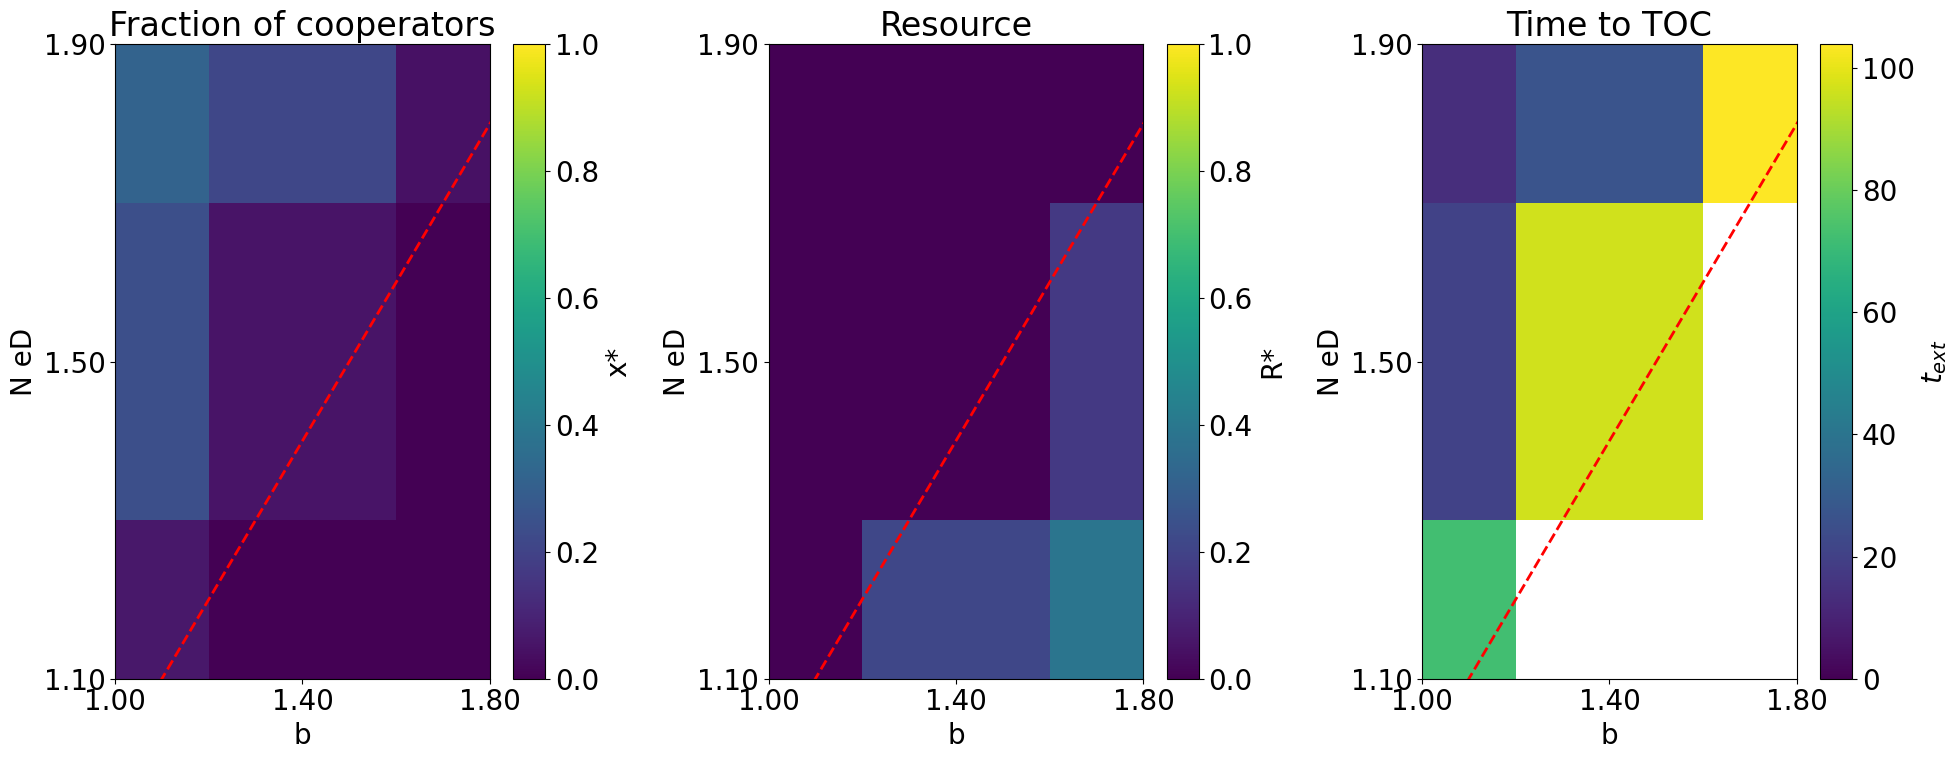

In [6]:
if dataObj_MF:    
    figPD_MF, axPD_MF = CPRSustPhaseDiagram(xStat_MF,RStat_MF,tExt_MF,PDParamLabels_MF,paramsPDGrid)

    plt.tight_layout()
    plt.show()

## Deterministic resource

Import data.

In [7]:
runDetRes = False

if runDetRes:
    fileList_detRes = [os.path.join(intputDirsVec[1], f) for f in os.listdir(intputDirsVec[1]) if f.endswith('.json')]
    dataObj_detRes = loadData(fileList_detRes)

## Visualize result of a single simulation

Note: these kind of simulations are obtained by multiple repetitions of a partially-stochastic simulation. Therefore, for each setting of the parameters, many repetitions are collected and the corresponding time series are averaged.

In [8]:
visSingle_detRes = True

if runDetRes and visSingle_detRes:
    if dataObj_detRes:
        idxVis_detRes = 0

        paramsDictVis_detRes = dataObj_detRes[idxVis_detRes][paramsLabel]
        print('Paremeter set')
        print(json.dumps(paramsDictVis_detRes, indent=4))
        seriesObjVis_detRes = dataObj_detRes[idxVis_detRes][seriesLabel]

        print('Evaluating the times to extinction')
        tExtObj_detRes = extinctionTimes(seriesObjVis_detRes)
        if not tExtObj_detRes['mean']:
            print('\tDone. The resource remains sustainable!')
        else:
            print(f'\tDone. {tExtObj_detRes['fraction']*100}% of the repetitions achieved extinction.')

        # Build a context object for evaluating the interpolating time series
        contextVis_detRes = rebuildContext(nodeStates,dataObj_detRes[idxVis_detRes])
        
        # Calculate averages
        if all(len(obj['time']) == 1 for obj in seriesObjVis_detRes):
            matchedMF = None
            for obj in dataObj_MF:
                params_temp = obj[paramsLabel]
                if all(params_temp.get(k) == v for k, v in paramsDictVis_detRes.items()):
                    matchedMF = obj 
                    break

            if matchedMF is None:
                raise ValueError('No mean field dataset was found for such set of parameters!')

            seriesObjVis_detRes = [matchedMF[seriesLabel].copy() for _ in range(len(seriesObjVis_detRes))]
            tSieriesVisAvg_detRes = matchedMF[seriesLabel]['time'].copy()    
        else:
            tSeriesVisAvg_detRes = tVecCommon(seriesObjVis_detRes,contextVis_detRes,reactsCPRsust_homogeneous_detRes)
        coopFracSeriesInterpVis_detRes = GillTimeSeriesInterp(tSeriesVisAvg_detRes,seriesObjVis_detRes,'cooperators')
        coopFracSeriesAvgVis_detRes = np.mean(coopFracSeriesInterpVis_detRes,axis=0)
        RSeriesInterpVis_detRes = GillTimeSeriesInterp(tSeriesVisAvg_detRes,seriesObjVis_detRes,'resource')
        RSeriesAvgVis_detRes = np.mean(RSeriesInterpVis_detRes,axis=0)
        
        # Redefine the object for plots because the mean field case may not be run
        plotsObj = [
            {
                'name' : 'Cooperators',
                'x' : [s['time'] for s in seriesObjVis_detRes],
                'xCommon' : tSeriesVisAvg_detRes,
                'y': [s['cooperators'] for s in seriesObjVis_detRes],
                'yMean' : coopFracSeriesAvgVis_detRes,
                'color' : 'royalblue',
                'xlabel' : 't',
                'ylabel' : 'x',
                'yLims' : [0, 1.1]
            },
            {
                'name' : 'Resource',
                'x' : [s['time'] for s in seriesObjVis_detRes],
                'xCommon' : tSeriesVisAvg_detRes,
                'y' : [s['resource'] for s in seriesObjVis_detRes],
                'yMean' : RSeriesAvgVis_detRes,
                'color' : 'limegreen',
                'xlabel' : 't',
                'ylabel' : 'R',
                'yLims' : [0,1.1]
            }
        ]

        fig_detRes, ax_detRes = CPRSustStocSimPlot(plotsObj)
        if tExtObj_detRes['mean']:
            ax_detRes[1].vlines(tExtObj_detRes['mean'],0,paramsDictVis_detRes['Ri'],colors='lime',linestyle='-.',label='Mean time to extinction')
            ax_detRes[1].legend()

        plt.show()

### Phase diagram

Choose a pair of parameters over which to plot the phase diagram. The code selects the relevant data sets.

In [9]:
if runDetRes and dataObj_detRes:
    # Pair of parameters over which to build the PD
    PDParamLabels_detRes = ['b','eD']
    
    paramsGenericDict_detRes = dataObj_detRes[0][paramsLabel]

    # Object of blocked parameters
    fixedParams_detRes = {k:v for k,v in paramsGenericDict_detRes.items() if k not in PDParamLabels_detRes}

     # Take only the data sets with the chosen parameters fixed
    dataObjPD_detRes = []
    for obj in dataObj_detRes:
        params_temp = obj[paramsLabel]
        if all(params_temp.get(k) == v for k, v in fixedParams_detRes.items()):
            dataObjPD_detRes.append(obj)

    paramsPDGrid = []
    xStat_detRes = []
    RStat_detRes = []
    tExt_detRes = []
    for obj in dataObjPD_detRes:
        paramsAll = obj[paramsLabel]
        paramsPD = [paramsAll[PDParamLabels_detRes[0]],paramsAll[PDParamLabels_detRes[1]]]
        for i, l in enumerate(PDParamLabels_detRes):
            if l.startswith('e'):
                paramsPD[i] = rescaleExtractionRate(paramsGenericDict_detRes['N'], paramsPD[i])
        paramsPDGrid.append({k: v for k,v in zip(PDParamLabels_detRes,paramsPD)})

        contextPD_detRes = rebuildContext(nodeStates,obj)

        seriesObjPD_detRes = obj[seriesLabel]
        
        tList = [o['time'] for o in seriesObjPD_detRes]
        xList = [o['cooperators'] for o in seriesObjPD_detRes]
        RList = [o['resource'] for o in seriesObjPD_detRes]

        # Calculate averages
        if all(len(tS) == 1 for tS in tList):
            matchedMF = None
            for obj in dataObj_MF:
                params_temp = obj[paramsLabel]
                if all(params_temp.get(k) == v for k, v in paramsAll.items()):
                    matchedMF = obj 
                    break

            if matchedMF is None:
                raise ValueError('No mean field dataset was found for such set of parameters!')

            seriesObjPD_detRes = [matchedMF[seriesLabel].copy() for _ in range(len(tList))]
            tSeriesPDAvg_detRes = matchedMF[seriesLabel]['time'].copy()    
        else:
            tSeriesPDAvg_detRes = tVecCommon(seriesObjPD_detRes,contextVis_detRes,reactsCPRsust_homogeneous_detRes)

        coopFracSeriesInterpPD_detRes = GillTimeSeriesInterp(tSeriesPDAvg_detRes,seriesObjPD_detRes,'cooperators')
        coopFracSeriesAvgPD_detRes = np.mean(coopFracSeriesInterpPD_detRes,axis=0)
        RSeriesInterpPD_detRes = GillTimeSeriesInterp(tSeriesPDAvg_detRes,seriesObjPD_detRes,'resource')
        RSeriesAvgPD_detRes = np.mean(RSeriesInterpPD_detRes,axis=0)

        tExt = extinctionTimes(seriesObjPD_detRes)
        if len(tExt['times'])== None:
            tExt['mean'] = np.nan

        cut = cutFrac*tSeriesPDAvg_detRes[-1]
        xStat_detRes.append(stationaryMean(tSeriesPDAvg_detRes,coopFracSeriesAvgPD_detRes,cut))
        RStat_detRes.append(stationaryMean(tSeriesPDAvg_detRes,RSeriesAvgPD_detRes,cut))
        tExt_detRes.append(tExt['mean'])
        

In [10]:
if runDetRes and dataObj_detRes:    
    figPD_detRes, axPD_detRes = CPRSustPhaseDiagram(xStat_detRes,RStat_detRes,tExt_detRes,PDParamLabels_detRes,paramsPDGrid)

    plt.tight_layout()
    plt.show()

# Stochastic resource

Import data.

In [11]:
fileList_stocRes = [os.path.join(intputDirsVec[2], f) for f in os.listdir(intputDirsVec[2]) if f.endswith('.json')]
dataObj_stocRes = loadData(fileList_stocRes)

9 files found:
[
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1.4_extractionRates0.0035_0.0055_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1_extractionRates0.0035_0.0055_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1.8_extractionRates0.0035_0.0055_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1.4_extractionRates0.0035_0.0075_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1.8_extractionRates0.0035_0.0075_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1_extractionRates0.0035_0.0075_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1.4_extractionRates0.0035_0.0095_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1.8_extractionRates0.0035_0.0095_xi0.5_Ri0.5.json",
    "output/stocRes/outStocRes_N2e+02_K1e+03_b1_extractionRates0.0035_0.0095_xi0.5_Ri0.5.json"
]
Importing.
Done.


## Visualize result of a single simulation

Note: these kind of simulations are obtained by multiple repetitions of a partially-stochastic simulation. Therefore, for each setting of the parameters, many repetitions are collected and the corresponding time series are averaged.

In [13]:
visSingle_stocRes = False

if dataObj_stocRes and visSingle_stocRes:
    idxVis_stocRes = -1

    paramsDictVis_stocRes = dataObj_stocRes[idxVis_stocRes][paramsLabel]
    print('Paremeter set')
    print(json.dumps(paramsDictVis_stocRes, indent=4))
    seriesObjVis_stocRes = dataObj_stocRes[idxVis_stocRes][seriesLabel]

    print('Evaluating the times to extinction')
    tExtObj_stocRes = extinctionTimes(seriesObjVis_stocRes)
    if not tExtObj_stocRes['mean']:
        print('\tDone. The resource remains sustainable!')
    else:
        print(f'\tDone. {tExtObj_stocRes['fraction']*100}% of the repetitions achieved extinction.')

    # Build a context object for evaluating the interpolating time series
    contextVis_stocRes = rebuildContext(nodeStates,dataObj_stocRes[idxVis_stocRes])
    
    # Calculate averages
    tSeriesVisAvg_stocRes = tVecCommon(seriesObjVis_stocRes,contextVis_stocRes,reactsCPRsust_homogeneous_stocRes)
    coopFracSeriesInterpVis_stocRes = GillTimeSeriesInterp(tSeriesVisAvg_stocRes,seriesObjVis_stocRes,'cooperators')
    coopFracSeriesAvgVis_stocRes = np.mean(coopFracSeriesInterpVis_stocRes,axis=0)
    RSeriesInterpVis_stocRes = GillTimeSeriesInterp(tSeriesVisAvg_stocRes,seriesObjVis_stocRes,'resource')
    RSeriesAvgVis_stocRes = np.mean(RSeriesInterpVis_stocRes,axis=0)
    
    # Redefine the object for plots because the previous cases may not be run
    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : [s['time'] for s in seriesObjVis_stocRes],
            'xCommon' : tSeriesVisAvg_stocRes,
            'y': [s['cooperators'] for s in seriesObjVis_stocRes],
            'yMean' : coopFracSeriesAvgVis_stocRes,
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : [s['time'] for s in seriesObjVis_stocRes],
            'xCommon' : tSeriesVisAvg_stocRes,
            'y' : [s['resource'] for s in seriesObjVis_stocRes],
            'yMean' : RSeriesAvgVis_stocRes,
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_stocRes, ax_stocRes = CPRSustStocSimPlot(plotsObj)
    if tExtObj_stocRes['mean']:
        ax_stocRes[1].vlines(tExtObj_stocRes['mean'],0,paramsDictVis_stocRes['Ri'],colors='lime',linestyle='-.',label='Mean time to extinction')
        ax_stocRes[1].legend()

    plt.show()

### Phase diagram

Choose a pair of parameters over which to plot the phase diagram. The code selects the relevant data sets.

In [24]:
if dataObj_stocRes:
    # Pair of parameters over which to build the PD
    PDParamLabels_stocRes = ['b','eD']
    
    paramsGenericDict_stocRes = dataObj_stocRes[0][paramsLabel]

    # Object of blocked parameters
    fixedParams_stocRes = {k:v for k,v in paramsGenericDict_stocRes.items() if k not in PDParamLabels_stocRes}

     # Take only the data sets with the chosen parameters fixed
    dataObjPD_stocRes = []
    for obj in dataObj_stocRes:
        params_temp = obj[paramsLabel]
        if all(params_temp.get(k) == v for k, v in fixedParams_stocRes.items()):
            dataObjPD_stocRes.append(obj)

    paramsPDGrid = []
    xStat_stocRes = []
    RStat_stocRes = []
    tExt_stocRes = []
    for obj in dataObjPD_stocRes:
        paramsAll = obj[paramsLabel]
        paramsPD = [paramsAll[PDParamLabels_stocRes[0]],paramsAll[PDParamLabels_stocRes[1]]]
        for i, l in enumerate(PDParamLabels_stocRes):
            if l.startswith('e'):
                paramsPD[i] = rescaleExtractionRate(paramsGenericDict_stocRes['N'], paramsPD[i])
        paramsPDGrid.append({k: v for k,v in zip(PDParamLabels_stocRes,paramsPD)})

        # Build a context object for evaluating the interpolating time series
        contextPD_stocRes = rebuildContext(nodeStates,obj)
    
        seriesObjPD_stocRes = obj[seriesLabel]

        tSeriesPDAvg_stocRes = tVecCommon(seriesObjPD_stocRes,contextPD_stocRes,reactsCPRsust_homogeneous_stocRes)
        coopFracSeriesInterpPD_stocRes = GillTimeSeriesInterp(tSeriesPDAvg_stocRes,seriesObjPD_stocRes,'cooperators')
        coopFracSeriesAvgPD_stocRes = np.mean(coopFracSeriesInterpPD_stocRes,axis=0)
        RSeriesInterpPD_stocRes = GillTimeSeriesInterp(tSeriesPDAvg_stocRes,seriesObjPD_stocRes,'resource')
        RSeriesAvgPD_stocRes = np.mean(RSeriesInterpPD_stocRes,axis=0)

        tExt = extinctionTimes(seriesObjPD_stocRes)
        if len(tExt['times'])== None:
            tExt['mean'] = np.nan

        cut = cutFrac*tSeriesPDAvg_stocRes[-1]
        xStat_stocRes.append(stationaryMean(tSeriesPDAvg_stocRes,coopFracSeriesAvgPD_stocRes,cut))
        RStat_stocRes.append(stationaryMean(tSeriesPDAvg_stocRes,RSeriesAvgPD_stocRes,cut))
        tExt_stocRes.append(tExt['mean'])

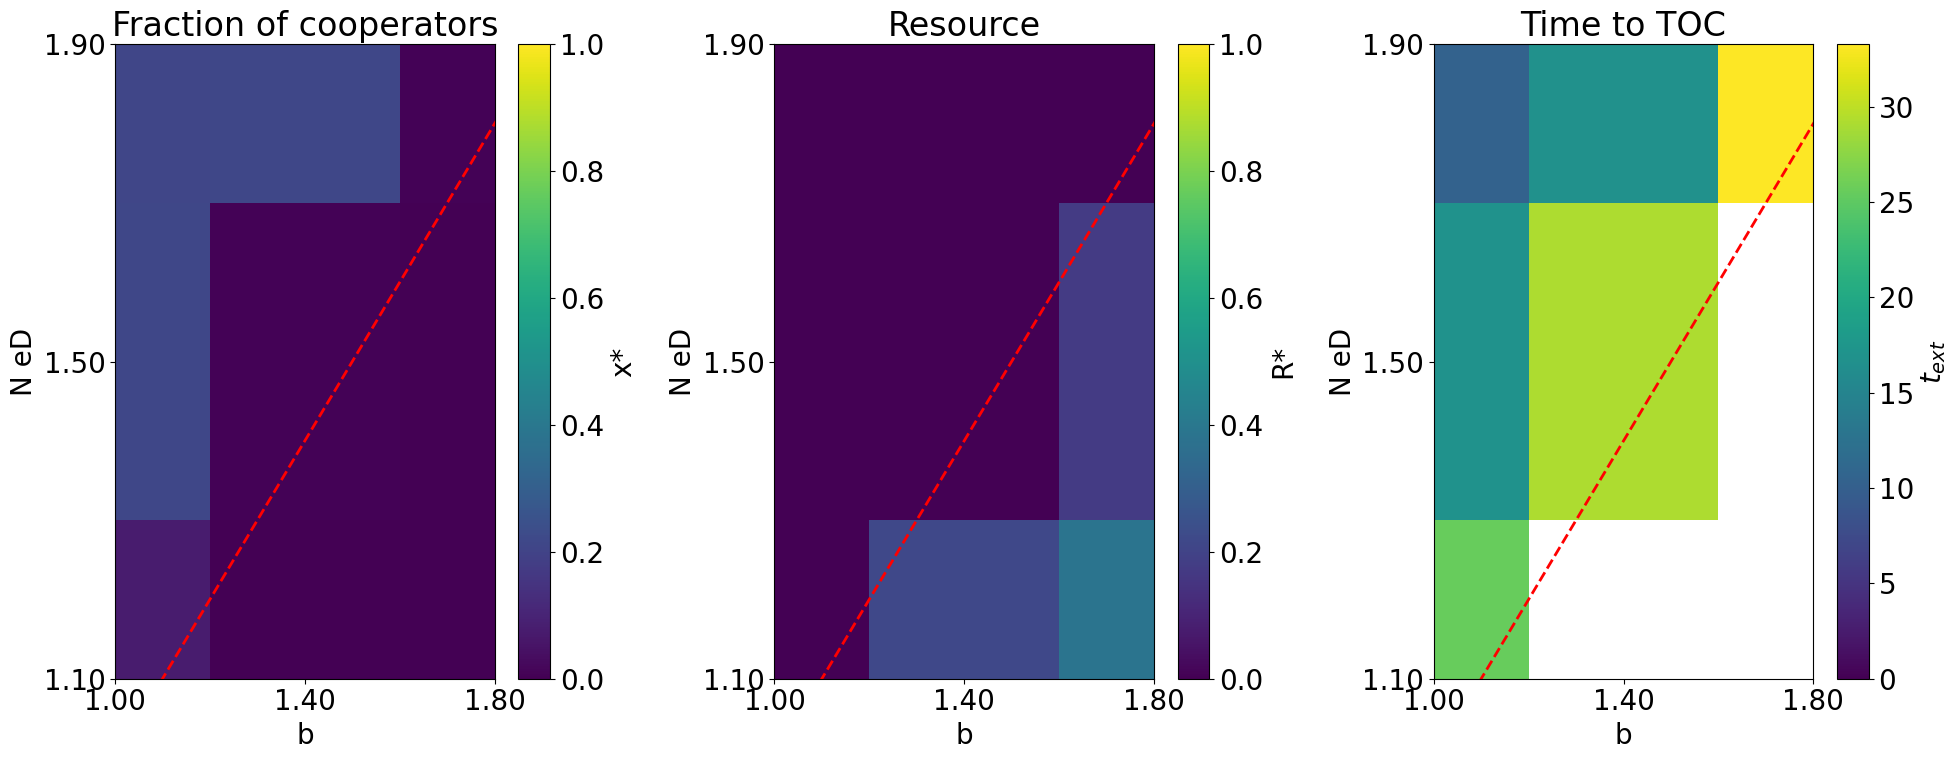

In [25]:
if dataObj_stocRes:    
    figPD_stocRes, axPD_stocRes = CPRSustPhaseDiagram(xStat_stocRes,RStat_stocRes,tExt_stocRes,PDParamLabels_stocRes,paramsPDGrid)

    plt.tight_layout()
    plt.show()